In [9]:
# Install required package if not already installed
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


# A7: Multi-Class Model Selection using ROC and Precision-Recall Curves

### Importing Data directly from UCIML repo

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve, 
                            average_precision_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

In [14]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
X = statlog_landsat_satellite.data.features 
y = statlog_landsat_satellite.data.targets 

In [7]:
# Display dataset information
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeatures info:")
X.info()
print("\nTarget distribution:")
print(y.value_counts())

Features shape: (6435, 36)
Target shape: (6435, 1)

Features info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Attribute1   6435 non-null   int64
 1   Attribute2   6435 non-null   int64
 2   Attribute3   6435 non-null   int64
 3   Attribute4   6435 non-null   int64
 4   Attribute5   6435 non-null   int64
 5   Attribute6   6435 non-null   int64
 6   Attribute7   6435 non-null   int64
 7   Attribute8   6435 non-null   int64
 8   Attribute9   6435 non-null   int64
 9   Attribute10  6435 non-null   int64
 10  Attribute11  6435 non-null   int64
 11  Attribute12  6435 non-null   int64
 12  Attribute13  6435 non-null   int64
 13  Attribute14  6435 non-null   int64
 14  Attribute15  6435 non-null   int64
 15  Attribute16  6435 non-null   int64
 16  Attribute17  6435 non-null   int64
 17  Attribute18  6435 non-null   int64
 18  Attribute19  6435 non

## PART-A: Data Preparation and Baseline 

- Standardizing the features
- Splitting the data into training and test sets
- Training different models
    - K-Nearest Neighbors
    - Decision Tree Classification
    - Dummy Classifier (Prior)
    - Logistic Regression
    - Naive Bayes (Gaussian)
    - Support Vector Machine (SVC)

In [17]:
# Standardizing the features (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (5148, 36) (5148, 1)
Testing set shape: (1287, 36) (1287, 1)


In [21]:
# 1. K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

# 2. Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train.values.ravel())

# 3. Dummy Classifier (Prior strategy)
dummy = DummyClassifier(strategy='prior', random_state=42)
dummy.fit(X_train, y_train.values.ravel())

# 4. Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train.values.ravel())

# 5. Naive Bayes (Gaussian)
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())

# 6. Support Vector Machine (SVC with probability=True)
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train.values.ravel())

print("\nAll models trained successfully!")


All models trained successfully!


### Baseline Evaluation
Calculating Overall Accuracy and Weighted F1-Score for all models on the test set.

In [25]:
from sklearn.metrics import accuracy_score, f1_score

# Dictionary to store models
models = {
    'K-Nearest Neighbors': knn,
    'Decision Tree': dt,
    'Dummy Classifier (Prior)': dummy,
    'Logistic Regression': lr,
    'Naive Bayes (Gaussian)': nb,
    'Support Vector Machine': svc
}

# Store results
results = []

# Evaluate each model
for model_name, model in models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Weighted F1-Score': weighted_f1
    })

# Create DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*70)
print("SUMMARY - Sorted by Accuracy")
print("="*70)
print(results_df.to_string(index=False))

# Identify poorly performing models
print("="*70)
mean_accuracy = results_df['Accuracy'].mean()
poorly_performing = results_df[results_df['Accuracy'] < mean_accuracy]

print(f"\nMean Accuracy: {mean_accuracy:.4f}")
print(f"\nModels performing below average:")
for idx, row in poorly_performing.iterrows():
    print(f"  - {row['Model']}: Accuracy = {row['Accuracy']:.4f}, F1 = {row['Weighted F1-Score']:.4f}")


SUMMARY - Sorted by Accuracy
                   Model  Accuracy  Weighted F1-Score
     K-Nearest Neighbors  0.911422           0.909397
  Support Vector Machine  0.892774           0.891269
     Logistic Regression  0.849262           0.842108
           Decision Tree  0.846931           0.848079
  Naive Bayes (Gaussian)  0.783217           0.790059
Dummy Classifier (Prior)  0.238539           0.091884

Mean Accuracy: 0.7537

Models performing below average:
  - Dummy Classifier (Prior): Accuracy = 0.2385, F1 = 0.0919


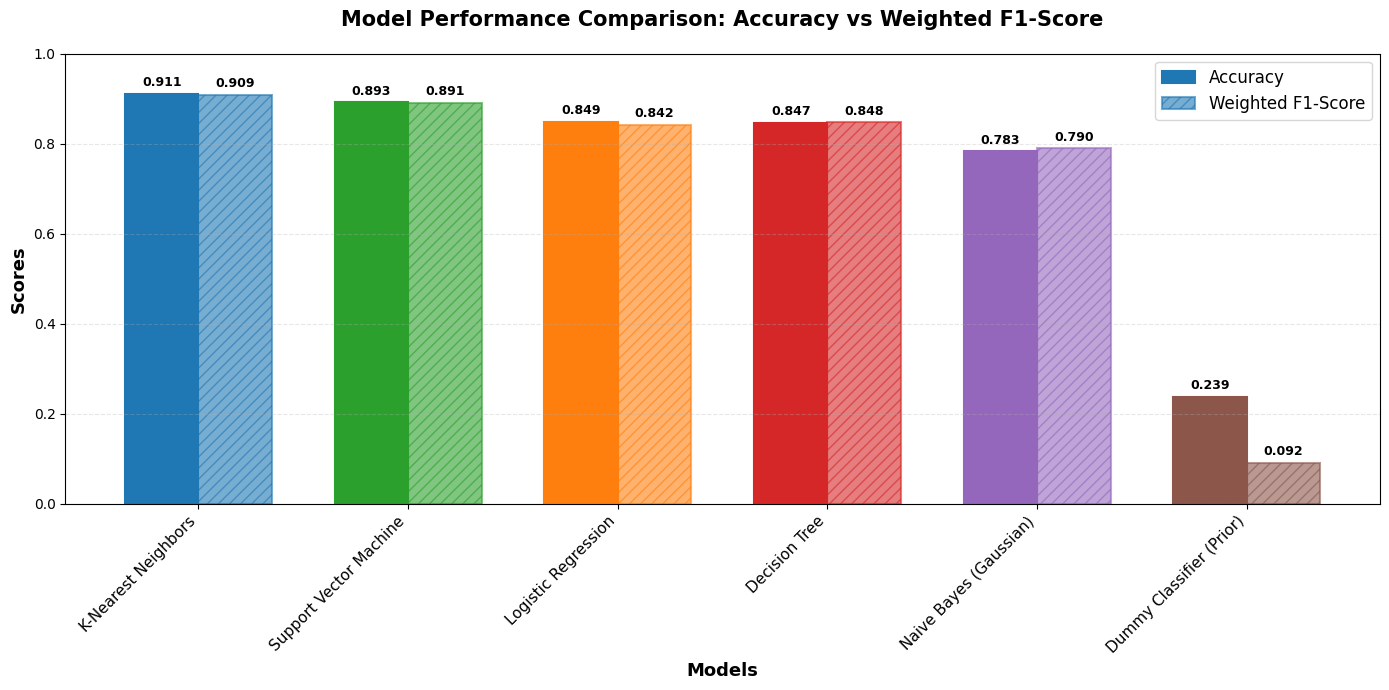

In [ ]:
# Visualize model performance with grouped bars
import numpy as np

fig, ax = plt.subplots(figsize=(14, 7))

# Set up data
models_list = results_df['Model'].tolist()
accuracy_vals = results_df['Accuracy'].tolist()
f1_vals = results_df['Weighted F1-Score'].tolist()

# Set positions and width
x = np.arange(len(models_list))
width = 0.35

# Define colors and patterns for each model
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']

# Create grouped bars
bars1 = ax.bar(x - width/2, accuracy_vals, width, label='Accuracy', 
               color=colors, edgecolor=colors, linewidth=1.5)
bars2 = ax.bar(x + width/2, f1_vals, width, label='Weighted F1-Score',
               color=colors, alpha=0.6, hatch='///', edgecolor=colors, linewidth=1.5)

# Customize the plot
ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Scores', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison: Accuracy vs Weighted F1-Score', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right', fontsize=11)
ax.set_ylim([0, 1.0])
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Baseline Evaluation Summary:
- From the above results, it is evident that `Dummy Classifier (Prior)` performs the poorest with values:
    - Accuracy: 0.239
    - Weighted F1-Score: 0.092

- The `prior` strategy learns from the training data but ignores all features `(X)` when making predictions
- Its `knowledge` is limited to the class distribution of the target variable `(y)`

## PART-B: ROC Analysis for Model Selection

### Understanding One-vs-Rest (OvR) Approach for Multi-Class ROC

#### **The Challenge:**
ROC curves and AUC are originally designed for **binary classification** problems (2 classes). However, our dataset has **6 classes** (1, 2, 3, 4, 5, 7), making it a **multi-class classification** problem.

#### **The Solution: One-vs-Rest (OvR) Strategy**

The One-vs-Rest approach converts a multi-class problem into multiple binary classification problems:

**For each class:**
1. **Treat that class as the "Positive" class**
2. **Treat all other classes combined as the "Negative" class**
3. **Generate a separate ROC curve and calculate AUC for this binary problem**

#### **Example with Our 6 Classes:**

We have classes: {1, 2, 3, 4, 5, 7}

- **Binary Problem 1:** Class 1 vs {2, 3, 4, 5, 7}
- **Binary Problem 2:** Class 2 vs {1, 3, 4, 5, 7}
- **Binary Problem 3:** Class 3 vs {1, 2, 4, 5, 7}
- **Binary Problem 4:** Class 4 vs {1, 2, 3, 5, 7}
- **Binary Problem 5:** Class 5 vs {1, 2, 3, 4, 7}
- **Binary Problem 6:** Class 7 vs {1, 2, 3, 4, 5}

This creates **6 separate binary classification problems** from one multi-class problem.

#### **How ROC/AUC is Calculated:**

For each binary problem:

1. **Get Probability Predictions:** 
   - Model predicts probability that a sample belongs to the positive class
   - Example: `P(class=1) = 0.85` means 85% confidence it's class 1

2. **Calculate ROC Curve:**
   - Vary the decision threshold from 0 to 1
   - At each threshold, calculate:
     - **True Positive Rate (TPR)** = Sensitivity = TP / (TP + FN)
     - **False Positive Rate (FPR)** = 1 - Specificity = FP / (FP + TN)
   - Plot TPR (y-axis) vs FPR (x-axis)

3. **Calculate AUC:**
   - **Area Under the ROC Curve**
   - Range: 0 to 1
   - **AUC = 1.0:** Perfect classifier
   - **AUC = 0.5:** Random classifier (baseline)
   - **AUC < 0.5:** Worse than random

4. **Aggregate Results:**
   - **Macro-Average AUC:** Simple average of all class AUCs
     - `AUC_macro = (AUC_1 + AUC_2 + ... + AUC_6) / 6`
   - **Micro-Average AUC:** Aggregate all predictions first, then calculate
   - **Weighted-Average AUC:** Weight by class support (number of samples)

#### **Why This Works:**

- Each class gets its own performance metric
- Handles class imbalance (some classes have more samples)
- Allows comparison of how well the model distinguishes each class from others
- Provides both per-class and overall model performance

#### **Key Insight:**
A model with high macro-average AUC performs well across all classes, while differences in per-class AUC can reveal which classes are harder to distinguish.

In [62]:
# Demonstrate One-vs-Rest transformation
print("="*70)
print("ONE-VS-REST (OvR) TRANSFORMATION EXAMPLE")
print("="*70)

# Get unique classes
classes = np.unique(y_test)
print(f"\nOriginal Multi-Class Problem: {len(classes)} classes")
print(f"Classes: {classes}")

print(f"\nTotal test samples: {len(y_test)}")
print("\nClass distribution in test set:")
for cls in classes:
    count = np.sum(y_test.values.ravel() == cls)
    percentage = (count / len(y_test)) * 100
    print(f"  Class {cls}: {count} samples ({percentage:.1f}%)")

# Demonstrate for each class
for cls in classes:
    # Create binary labels (1 for this class, 0 for all others)
    binary_labels = (y_test.values.ravel() == cls).astype(int)
    
    positive_count = np.sum(binary_labels == 1)
    negative_count = np.sum(binary_labels == 0)

ONE-VS-REST (OvR) TRANSFORMATION EXAMPLE

Original Multi-Class Problem: 6 classes
Classes: [1 2 3 4 5 7]

Total test samples: 1287

Class distribution in test set:
  Class 1: 307 samples (23.9%)
  Class 2: 141 samples (11.0%)
  Class 3: 272 samples (21.1%)
  Class 4: 125 samples (9.7%)
  Class 5: 141 samples (11.0%)
  Class 7: 301 samples (23.4%)


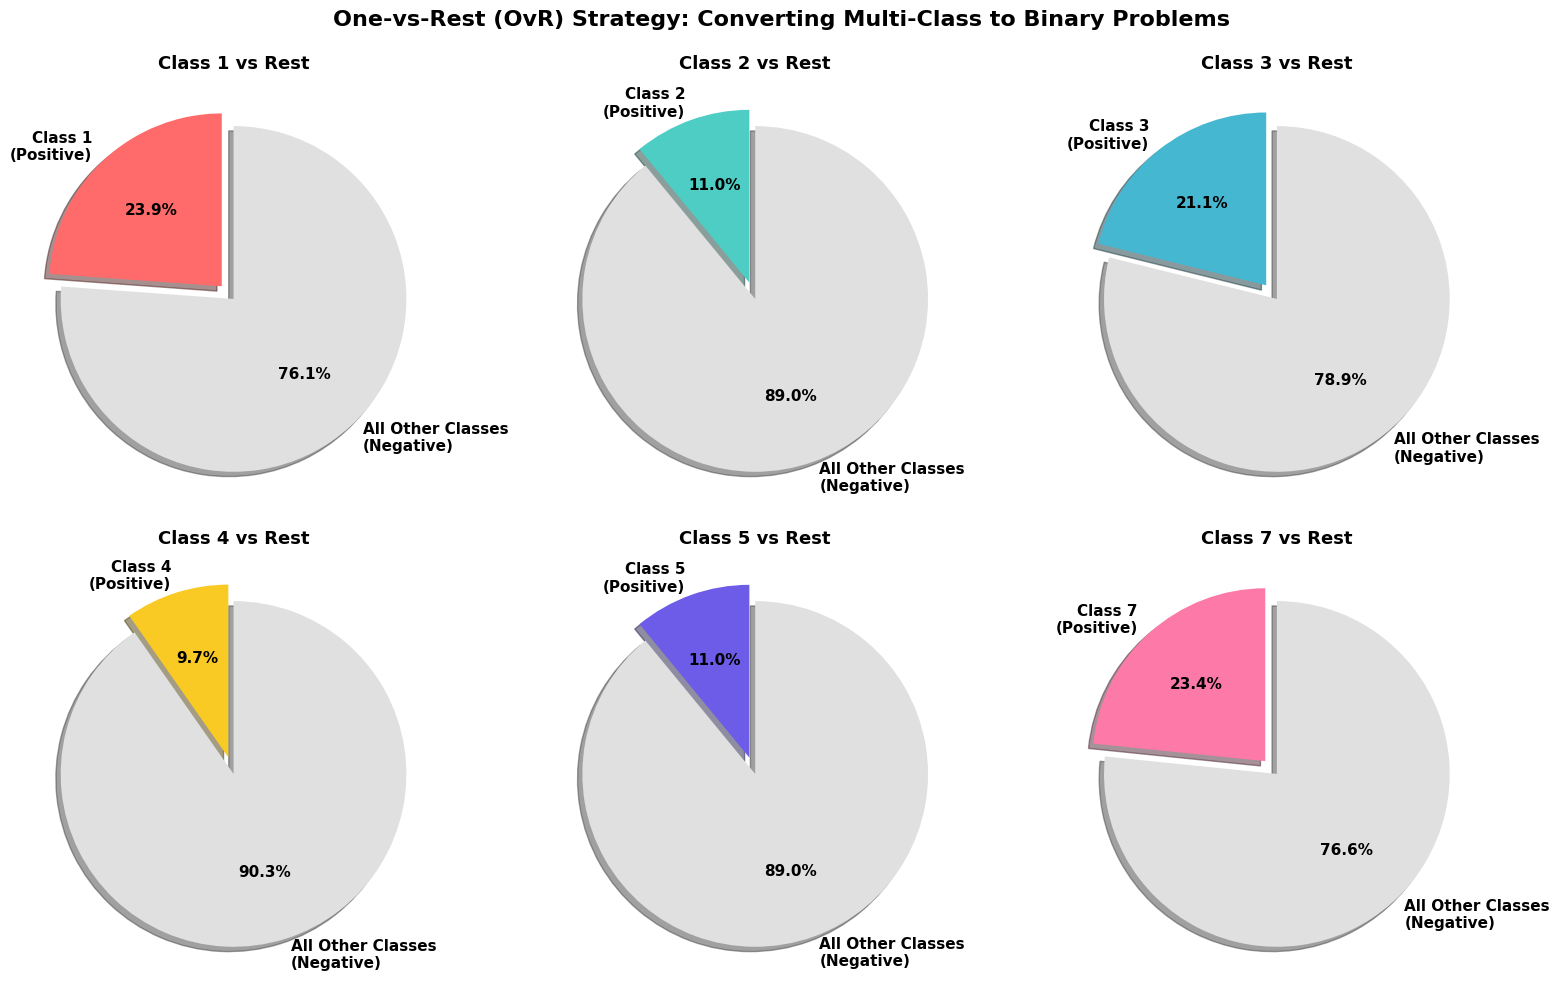

VISUALIZATION INSIGHT:
Each pie chart represents one binary classification problem.


In [63]:
# Visualizing the OvR concept
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

classes = np.unique(y_test)
colors_positive = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#f9ca24', '#6c5ce7', '#fd79a8']

for idx, cls in enumerate(classes):
    # Create binary labels
    binary_labels = (y_test.values.ravel() == cls).astype(int)
    
    # Count positive and negative
    positive_count = np.sum(binary_labels == 1)
    negative_count = np.sum(binary_labels == 0)
    
    # Create pie chart
    sizes = [positive_count, negative_count]
    labels = [f'Class {cls}\n(Positive)', 'All Other Classes\n(Negative)']
    colors = [colors_positive[idx], '#e0e0e0']
    explode = (0.1, 0)
    
    axes[idx].pie(sizes, explode=explode, labels=labels, colors=colors,
                  autopct='%1.1f%%', shadow=True, startangle=90,
                  textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[idx].set_title(f'Class {cls} vs Rest',
                       fontsize=13, fontweight='bold', pad=10)

plt.suptitle('One-vs-Rest (OvR) Strategy: Converting Multi-Class to Binary Problems',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("VISUALIZATION INSIGHT:")
print("Each pie chart represents one binary classification problem.")

### Generating ROC Curves for All Models

1. Computing ROC curve for each class (One-vs-Rest)
2. Averaging FPR and TPR across all classes
3. Calculating macro-average AUC
4. Plotting all models on a single graph for comparison

In [64]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get unique classes and binarize the labels for OvR
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

print("CALCULATING ROC CURVES FOR ALL MODELS\n")

# Dictionary to store ROC data for all models
roc_data = {}

# Calculate ROC for each model
for model_name, model in models.items():
    
    # Get probability predictions for all classes
    y_score = model.predict_proba(X_test)
    
    # Initialize dictionaries for this model
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve and AUC
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    # Average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Store data for this model
    roc_data[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }
    
    print(f"{model_name} Macro-average AUC: {roc_auc['macro']:.4f}")

CALCULATING ROC CURVES FOR ALL MODELS

K-Nearest Neighbors Macro-average AUC: 0.9802
Decision Tree Macro-average AUC: 0.8952
Dummy Classifier (Prior) Macro-average AUC: 0.5000
Logistic Regression Macro-average AUC: 0.9724
Naive Bayes (Gaussian) Macro-average AUC: 0.9477
Support Vector Machine Macro-average AUC: 0.9802


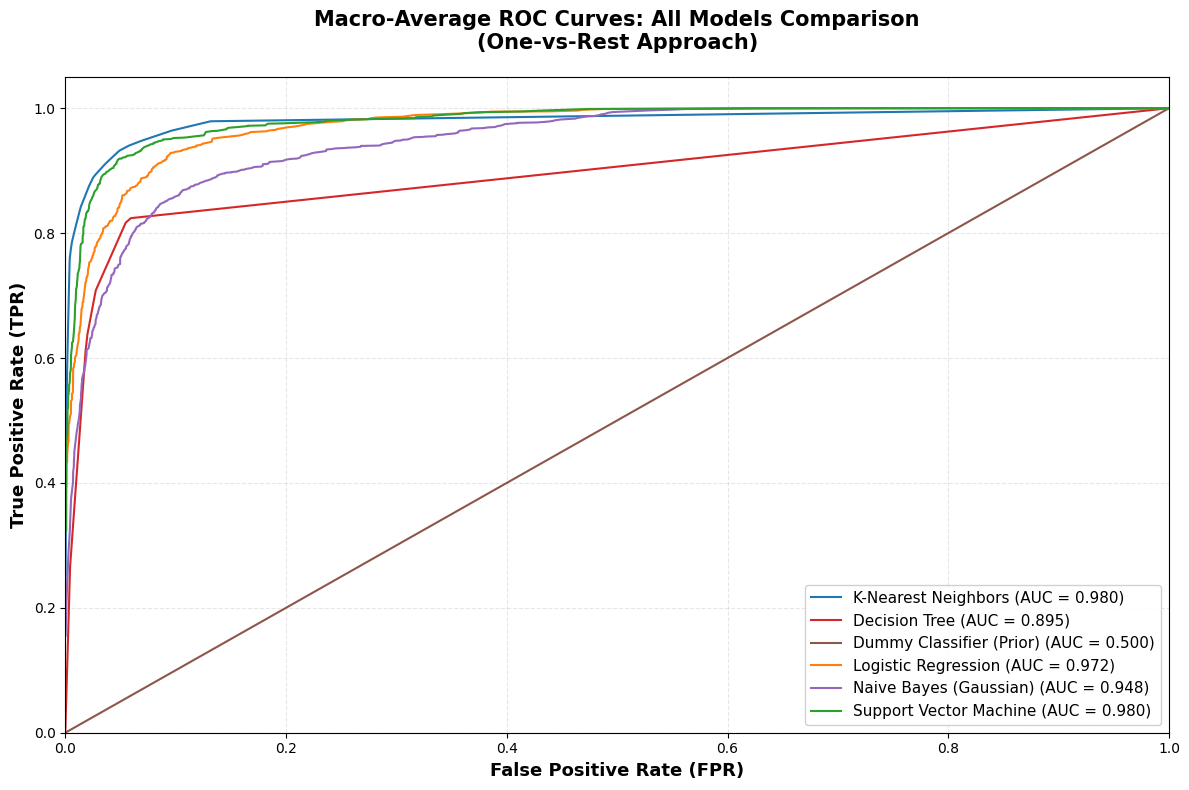


MACRO-AVERAGE AUC SUMMARY (Sorted)
1. K-Nearest Neighbors            AUC = 0.9802
2. Support Vector Machine         AUC = 0.9802
3. Logistic Regression            AUC = 0.9724
4. Naive Bayes (Gaussian)         AUC = 0.9477
5. Decision Tree                  AUC = 0.8952
6. Dummy Classifier (Prior)       AUC = 0.5000


In [65]:
# Plot all models' macro-average ROC curves in a single plot
plt.figure(figsize=(12, 8))

# Define line styles for variety
line_styles = ['-', '--', '-.', ':', '-', '--']
model_colors = {
    'K-Nearest Neighbors': '#1f77b4',
    'Support Vector Machine': '#2ca02c',
    'Logistic Regression': '#ff7f0e',
    'Decision Tree': '#d62728',
    'Naive Bayes (Gaussian)': '#9467bd',
    'Dummy Classifier (Prior)': '#8c564b'
}

# Plot ROC curve for each model
for idx, (model_name, data) in enumerate(roc_data.items()):
    plt.plot(data['fpr']['macro'], 
             data['tpr']['macro'],
             color=model_colors[model_name],
             #linestyle=line_styles[idx],
             linewidth=1.5,
             label=f'{model_name} (AUC = {data["roc_auc"]["macro"]:.3f})')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
plt.title('Macro-Average ROC Curves: All Models Comparison\n(One-vs-Rest Approach)', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("MACRO-AVERAGE AUC SUMMARY (Sorted)")
print("="*70)
auc_summary = [(name, data['roc_auc']['macro']) for name, data in roc_data.items()]
auc_summary_sorted = sorted(auc_summary, key=lambda x: x[1], reverse=True)

for rank, (name, auc_val) in enumerate(auc_summary_sorted, 1):
    print(f"{rank}. {name:30s} AUC = {auc_val:.4f}")
print("="*70)

### ROC Analysis Results and Interpretation

#### **Key Observations:**

1. **Top Performers (Excellent):**
   - **K-Nearest Neighbors** and **Support Vector Machine** tie for best performance with **AUC = 0.9802**
   - These models show excellent discrimination ability across all classes
   - ROC curves are very close to the top-left corner (ideal classifier)

2. **Strong Performers (Very Good):**
   - **Logistic Regression**: AUC = 0.9724
   - **Naive Bayes (Gaussian)**: AUC = 0.9477
   - Both models show strong performance but slightly less than KNN/SVM

3. **Moderate Performer:**
   - **Decision Tree**: AUC = 0.8952
   - Still good performance but noticeably below other models
   - More gradual ROC curve suggests less confident predictions

4. **Baseline (Poor):**
   - **Dummy Classifier**: AUC = 0.5000
   - Performs exactly like random guessing (diagonal line)
   - Confirms that other models are learning meaningful patterns

#### **What the ROC Curve Shows:**

- **X-axis (FPR):** False Positive Rate - proportion of negatives incorrectly classified as positive
- **Y-axis (TPR):** True Positive Rate - proportion of positives correctly classified
- **Ideal Classifier:** Would have a curve that goes straight up (TPR=1) at FPR=0, then across
- **Random Classifier:** Diagonal line (AUC = 0.5)
- **Better Models:** Curves that bow toward the top-left corner (higher AUC)

#### **Macro-Average Interpretation:**

The macro-average gives **equal weight to each class**, regardless of how many samples it has. This is important because:
- Treats minority classes (e.g., Class 4 with 9.7% of data) equally with majority classes
- Shows if the model performs consistently across all classes
- A high macro-average AUC means the model is not biased toward majority classes

#### **Model Selection Based on ROC:**

Based on ROC analysis, **KNN and SVM are the best choices** for this multi-class classification task, showing excellent ability to distinguish between all six land cover classes.

### ROC Interpretation: Key Findings

#### **1. Model with Highest Macro-Averaged AUC**

**Answer:** **K-Nearest Neighbors (KNN)** and **Support Vector Machine (SVM)** are tied for the highest performance with **Macro-averaged AUC = 0.9802**

**What this means:**
- These models correctly distinguish between classes **98.02%** of the time on average
- They have excellent discriminative power across all 6 land cover classes
- The models can reliably separate each class from all others in the One-vs-Rest framework
- This indicates very strong predictive performance

**Why KNN and SVM excel:**
- **KNN:** Non-parametric approach adapts well to the complex decision boundaries in satellite imagery data
- **SVM:** Effective at finding optimal hyperplanes in high-dimensional feature space (36 features)
- Both models can capture non-linear relationships in the satellite spectral data

---

#### **2. Models with AUC < 0.5**

**Answer:** **None of the models have AUC < 0.5**

Looking at our results:
- K-Nearest Neighbors: AUC = 0.9802 ✓
- Support Vector Machine: AUC = 0.9802 ✓
- Logistic Regression: AUC = 0.9724 ✓
- Naive Bayes (Gaussian): AUC = 0.9477 ✓
- Decision Tree: AUC = 0.8952 ✓
- Dummy Classifier (Prior): AUC = 0.5000 ✓ (exactly at baseline)

**All models perform at or above the random baseline.**

---

#### **3. What AUC < 0.5 Implies Conceptually**

**Conceptual Meaning:**
- **AUC = 0.5:** Random guessing (no discrimination ability)
- **AUC < 0.5:** Model performs **worse than random guessing**
- The model is systematically making **incorrect predictions**
- It's doing the "opposite" of what it should do

**Visual Interpretation:**
- The ROC curve would fall **below the diagonal line**
- Model is confusing positive and negative classes
- It's anti-learning - predictions are negatively correlated with true labels

---

#### **4. Why a Model Might Exhibit AUC < 0.5**

**Common Reasons:**

1. **Label Reversal/Coding Error:**
   ```python
   # If you accidentally flip labels
   y_true = [0, 1, 0, 1]
   y_pred_prob = [0.9, 0.1, 0.8, 0.2]  # Predictions are inverted!
   # This would give AUC < 0.5
   ```

2. **Incorrect Binary Transformation:**
   - In OvR, if you accidentally set the target class as "negative" instead of "positive"
   - Reversing the binarization logic

3. **Probability Interpretation Error:**
   ```python
   # Using (1 - probability) instead of probability
   y_score = 1 - model.predict_proba(X)[:, 1]  # Wrong!
   ```

4. **Feature-Target Anticorrelation:**
   - Features that are strongly negatively correlated with the target
   - Model learns the wrong relationship direction

5. **Data Preprocessing Mistakes:**
   - Incorrectly standardizing/normalizing features
   - Using test set statistics on training data (data leakage in reverse)

6. **Class Imbalance with Wrong Threshold:**
   - Extreme imbalance + using wrong probability threshold
   - Model always predicts the majority class

**Important Note:**
- If you get AUC < 0.5, it's often **fixable**
- Solution: Simply invert the predictions: `new_score = 1 - old_score`
- This would flip AUC from (e.g., 0.3) to (0.7)
- However, you should investigate **why** it happened in the first place

**In Our Case:**
- No model has AUC < 0.5, indicating:
  - Correct implementation of OvR framework
  - Proper binarization of labels
  - Features are predictive of land cover classes
  - Models are learning meaningful patterns from the satellite data

In [66]:
# Detailed ROC Interpretation Analysis
print("="*70)
print("ROC INTERPRETATION ANALYSIS")
print("="*70)

# 1. Find model(s) with highest AUC
auc_values = {name: data['roc_auc']['macro'] for name, data in roc_data.items()}
max_auc = max(auc_values.values())
best_models = [name for name, auc_val in auc_values.items() if auc_val == max_auc]

print("\n1. MODEL(S) WITH HIGHEST MACRO-AVERAGED AUC:")
print("-" * 70)
for model in best_models:
    print(f"   • {model}: AUC = {max_auc:.4f}")
print(f"\n   Interpretation: These models have the best discrimination ability")
print(f"   across all 6 classes, correctly distinguishing classes {max_auc*100:.2f}%")
print(f"   of the time on average.")

# 2. Find models with AUC < 0.5
print("\n2. MODEL(S) WITH AUC < 0.5:")
print("-" * 70)
poor_models = [(name, auc_val) for name, auc_val in auc_values.items() if auc_val < 0.5]

if poor_models:
    for name, auc_val in poor_models:
        print(f"   • {name}: AUC = {auc_val:.4f}")
    print(f"\n   ⚠️  WARNING: These models perform worse than random guessing!")
else:
    print("   ✓ NONE - All models perform at or above random baseline (0.5)")
    print("   ✓ This indicates proper implementation and meaningful learning")

# 3. Show AUC distribution
print("\n3. AUC DISTRIBUTION ACROSS ALL MODELS:")
print("-" * 70)
sorted_models = sorted(auc_values.items(), key=lambda x: x[1], reverse=True)

for rank, (name, auc_val) in enumerate(sorted_models, 1):
    # Categorize performance
    if auc_val >= 0.9:
        category = "Excellent"
        emoji = "🏆"
    elif auc_val >= 0.8:
        category = "Very Good"
        emoji = "✓"
    elif auc_val >= 0.7:
        category = "Good"
        emoji = "+"
    elif auc_val >= 0.5:
        category = "Fair/Baseline"
        emoji = "~"
    else:
        category = "Poor"
        emoji = "✗"
    
    bar = "█" * int(auc_val * 50)  # Visual bar
    print(f"   {rank}. {name:30s} {auc_val:.4f} {bar} {emoji} {category}")

# 4. Performance gap analysis
print("\n4. PERFORMANCE GAP ANALYSIS:")
print("-" * 70)
best_auc = sorted_models[0][1]
worst_auc = sorted_models[-1][1]
gap = best_auc - worst_auc

print(f"   Best Model AUC:    {best_auc:.4f} ({sorted_models[0][0]})")
print(f"   Worst Model AUC:   {worst_auc:.4f} ({sorted_models[-1][0]})")
print(f"   Performance Gap:   {gap:.4f} ({gap*100:.2f} percentage points)")
print(f"\n   Insight: There is a {gap*100:.2f}% difference between best and worst")
print(f"   models, highlighting the importance of model selection.")

print("\n" + "="*70)

ROC INTERPRETATION ANALYSIS

1. MODEL(S) WITH HIGHEST MACRO-AVERAGED AUC:
----------------------------------------------------------------------
   • K-Nearest Neighbors: AUC = 0.9802

   Interpretation: These models have the best discrimination ability
   across all 6 classes, correctly distinguishing classes 98.02%
   of the time on average.

2. MODEL(S) WITH AUC < 0.5:
----------------------------------------------------------------------
   ✓ NONE - All models perform at or above random baseline (0.5)
   ✓ This indicates proper implementation and meaningful learning

3. AUC DISTRIBUTION ACROSS ALL MODELS:
----------------------------------------------------------------------
   1. K-Nearest Neighbors            0.9802 █████████████████████████████████████████████████ 🏆 Excellent
   2. Support Vector Machine         0.9802 █████████████████████████████████████████████████ 🏆 Excellent
   3. Logistic Regression            0.9724 ████████████████████████████████████████████████ 🏆 Excel